In [1]:
import torch
import torchvision 
from tqdm import tqdm
import matplotlib

In [2]:
#如果网络能在GPU中训练，就使用GPU；否则使用CPU进行训练
device = "cuda:0" if torch.cuda.is_available() else "cpu"

#这个函数包括了两个操作：将图片转换为张量，以及将图片进行归一化处理
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                torchvision.transforms.Normalize(mean = [0.5],std = [0.5])])

In [4]:
path = r'E:\handwriting_recognize\DATASET/'  #数据集下载后保存的目录

#下载训练集和测试集
trainData = torchvision.datasets.MNIST(path,train = True,transform = transform,download = False)
testData = torchvision.datasets.MNIST(path,train = False,transform = transform,download=False)

In [5]:
#设定每一个Batch的大小
BATCH_SIZE = 256  

#构建数据集和测试集的DataLoader
trainDataLoader = torch.utils.data.DataLoader(dataset = trainData,batch_size = BATCH_SIZE,shuffle = True)
testDataLoader = torch.utils.data.DataLoader(dataset = testData,batch_size = BATCH_SIZE)

In [6]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.model = torch.nn.Sequential(
            #The size of the picture is 28x28
            torch.nn.Conv2d(in_channels = 1,out_channels = 16,kernel_size = 3,stride = 1,padding = 1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size = 2,stride = 2),
            
            #The size of the picture is 14x14
            torch.nn.Conv2d(in_channels = 16,out_channels = 32,kernel_size = 3,stride = 1,padding = 1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size = 2,stride = 2),
            
            #The size of the picture is 7x7
            torch.nn.Conv2d(in_channels = 32,out_channels = 64,kernel_size = 3,stride = 1,padding = 1),
            torch.nn.ReLU(),
            
            torch.nn.Flatten(),
            torch.nn.Linear(in_features = 7 * 7 * 64,out_features = 128),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features = 128,out_features = 10),
            torch.nn.Softmax(dim=1)
        )
        
    def forward(self,input):
        output = self.model(input)
        return output

In [7]:
net = Net()
#将模型转换到device中，并将其结构显示出来
print(net.to(device))  

Net(
  (model): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=3136, out_features=128, bias=True)
    (10): ReLU()
    (11): Linear(in_features=128, out_features=10, bias=True)
    (12): Softmax(dim=1)
  )
)


In [8]:
lossF = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters())

In [9]:
import time

In [10]:
EPOCHS = 10
#存储训练过程
history = {'Test Loss':[],'Test Accuracy':[]}
start_time=time.time()
for epoch in range(1,EPOCHS + 1):
    processBar = tqdm(trainDataLoader,unit = 'step')
    net.train(True)
    for step,(trainImgs,labels) in enumerate(processBar):
        trainImgs = trainImgs.to(device)
        labels = labels.to(device)

        net.zero_grad()
        outputs = net(trainImgs)
        loss = lossF(outputs,labels)
        predictions = torch.argmax(outputs, dim = 1)
        accuracy = torch.sum(predictions == labels)/labels.shape[0]
        loss.backward()

        optimizer.step()
        processBar.set_description("[%d/%d] Loss: %.4f, Acc: %.4f" % 
                                   (epoch,EPOCHS,loss.item(),accuracy.item()))
        
        if step == len(processBar)-1:
            correct,totalLoss = 0,0
            net.train(False)
            for testImgs,labels in testDataLoader:
                testImgs = testImgs.to(device)
                labels = labels.to(device)
                outputs = net(testImgs)
                loss = lossF(outputs,labels)
                predictions = torch.argmax(outputs,dim = 1)
                
                totalLoss += loss
                correct += torch.sum(predictions == labels)
            testAccuracy = correct/(BATCH_SIZE * len(testDataLoader))
            testLoss = totalLoss/len(testDataLoader)
            history['Test Loss'].append(testLoss.item())
            history['Test Accuracy'].append(testAccuracy.item())
            processBar.set_description("[%d/%d] Loss: %.4f, Acc: %.4f, Test Loss: %.4f, Test Acc: %.4f" % 
                                   (epoch,EPOCHS,loss.item(),accuracy.item(),testLoss.item(),testAccuracy.item()))
    processBar.close()
end_time=time.time()
print(end_time-start_time)

[1/10] Loss: 1.4621, Acc: 0.9479, Test Loss: 1.5002, Test Acc: 0.9402: 100%|██████████| 235/235 [00:13<00:00, 17.91step/s]
[2/10] Loss: 1.4612, Acc: 0.9792, Test Loss: 1.4827, Test Acc: 0.9557: 100%|██████████| 235/235 [00:07<00:00, 30.01step/s]
[3/10] Loss: 1.4612, Acc: 0.9479, Test Loss: 1.4803, Test Acc: 0.9587: 100%|██████████| 235/235 [00:08<00:00, 26.73step/s]
[4/10] Loss: 1.4612, Acc: 1.0000, Test Loss: 1.4760, Test Acc: 0.9627: 100%|██████████| 235/235 [00:09<00:00, 25.69step/s]
[5/10] Loss: 1.4612, Acc: 0.9792, Test Loss: 1.4763, Test Acc: 0.9614: 100%|██████████| 235/235 [00:08<00:00, 27.16step/s]
[6/10] Loss: 1.4612, Acc: 0.9896, Test Loss: 1.4740, Test Acc: 0.9640: 100%|██████████| 235/235 [00:09<00:00, 25.63step/s]
[7/10] Loss: 1.4612, Acc: 0.9896, Test Loss: 1.4718, Test Acc: 0.9663: 100%|██████████| 235/235 [00:08<00:00, 27.55step/s]
[8/10] Loss: 1.4612, Acc: 0.9792, Test Loss: 1.4731, Test Acc: 0.9651: 100%|██████████| 235/235 [00:07<00:00, 29.67step/s]
[9/10] Loss: 1.4

91.33856081962585


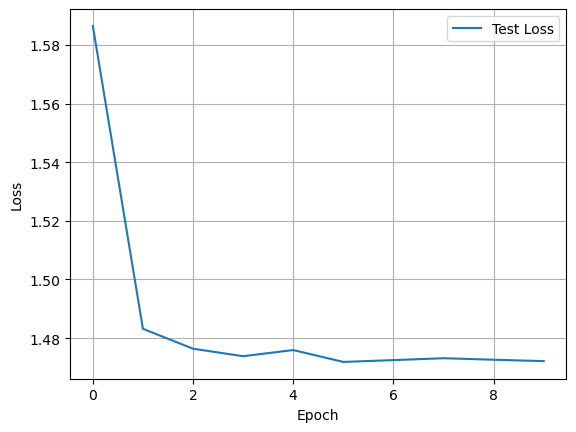

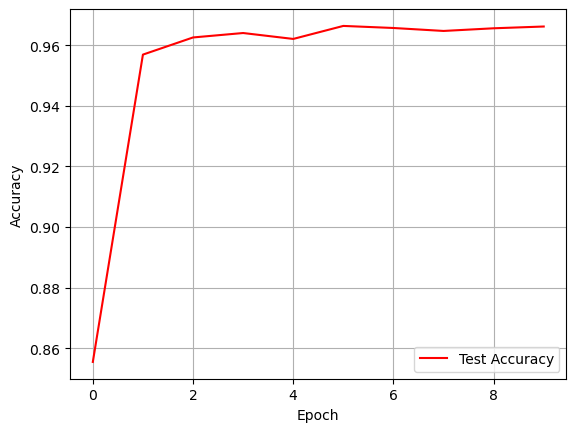

In [10]:
import matplotlib.pyplot as plt
#对测试Loss进行可视化
matplotlib.pyplot.plot(history['Test Loss'],label = 'Test Loss')
matplotlib.pyplot.legend(loc='best')
matplotlib.pyplot.grid(True)
matplotlib.pyplot.xlabel('Epoch')
matplotlib.pyplot.ylabel('Loss')
matplotlib.pyplot.show()

#对测试准确率进行可视化
matplotlib.pyplot.plot(history['Test Accuracy'],color = 'red',label = 'Test Accuracy')
matplotlib.pyplot.legend(loc='best')
matplotlib.pyplot.grid(True)
matplotlib.pyplot.xlabel('Epoch')
matplotlib.pyplot.ylabel('Accuracy')
matplotlib.pyplot.show()

In [16]:
torch.save(net,'E:/handwriting_recognize/result_hwr/model1.pth')